<a href="https://colab.research.google.com/github/kalleo1996/pysparkMLExample/blob/main/date_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     |████████████████████████████████| 212.4MB 65kB/s 
     |████████████████████████████████| 204kB 16.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=6c73e7a1e63aa8da5c3c0ff79fe32ca257cd20d419161a5a0e76f6da3ed6e525
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", "15g") \
    .appName("Exploratory Analysis") \
    .getOrCreate()

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
parking2017 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('/content/gdrive/My Drive/Big Data/Parking_Violations_Issued_-_Fiscal_Year_2017.csv')
parking2016 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('/content/gdrive/My Drive/Big Data/Parking_Violations_Issued_-_Fiscal_Year_2016.csv')
parking2015 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('/content/gdrive/My Drive/Big Data/Parking_Violations_Issued_-_Fiscal_Year_2015.csv')
parking2014 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('/content/gdrive/My Drive/Big Data/Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv')

In [ ]:
parking2017 = parking2017.dropDuplicates()
parking2016 = parking2016.dropDuplicates()
parking2015 = parking2015.dropDuplicates()
parking2014 = parking2014.dropDuplicates()

In [ ]:
columns_to_drop = ['Double Parking Violation', 'Hydrant Violation','No Standing or Stopping Violation', 'Meter Number', 'Unregistered Vehicle?', 'Violation Legal Code', 'Intersecting Street', 'Time First Observed', 'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad', 'Violation In Front Of Or Opposite', 'House Number', 'Vehicle Color', 'From Hours In Effect', 'Days Parking In Effect    ', 'Days Parking In Effect', 'Violation Post Code' ]
parking2017 = parking2017.drop(*columns_to_drop)
parking2016 = parking2016.drop(*columns_to_drop)
parking2015 = parking2015.drop(*columns_to_drop)
parking2014 = parking2014.drop(*columns_to_drop)

In [ ]:
parking2017 = parking2017.na.drop(subset=["Plate ID","Violation Time","Sub Division","Violation Description","Violation Location","Street Name","Violation County"])
parking2016 = parking2016.na.drop(subset=["Plate ID","Violation Time","Sub Division","Violation Description","Violation Location","Street Name","Violation County"])
parking2015 = parking2015.na.drop(subset=["Plate ID","Violation Time","Sub Division","Violation Description","Violation Location","Street Name","Violation County"])
parking2014 = parking2014.na.drop(subset=["Plate ID","Violation Time","Sub Division","Violation Description","Violation Location","Street Name","Violation County"])

In [ ]:
parking2017 = parking2017.toDF(*(c.replace(' ', '_') for c in parking2017.columns))
parking2016 = parking2016.toDF(*(c.replace(' ', '_') for c in parking2016.columns))
parking2015 = parking2015.toDF(*(c.replace(' ', '_') for c in parking2015.columns))
parking2014 = parking2014.toDF(*(c.replace(' ', '_') for c in parking2014.columns))

In [ ]:
colNames = ["Vehicle_Make"]
parking2017 = parking2017.na.fill("FORD", colNames)
parking2016 = parking2016.na.fill("FORD", colNames)
parking2015 = parking2015.na.fill("FORD", colNames)
parking2014 = parking2014.na.fill("FORD", colNames)

# Predictions

In [ ]:
from pyspark.sql.functions import unix_timestamp, from_unixtime

parking2017.createOrReplaceTempView("parkingtable2017")
parking2016.createOrReplaceTempView("parkingtable2016")
parking2015.createOrReplaceTempView("parkingtable2015")
parking2014.createOrReplaceTempView("parkingtable2014")

In [ ]:
from pyspark.sql.functions import udf,desc
from datetime import datetime

In [ ]:


from pyspark.sql.functions import date_format
from pyspark.sql.functions import to_date, date_format

from pyspark.sql.functions import *


In [ ]:
data_2017 = spark.sql("select year(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as year,month(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as month,day(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as day,Violation_Location, Violation_Code , count(*) as frequency from parkingtable2017  Group by year,month,day,Violation_Location, Violation_Code order by year,month,day,Violation_Location,Violation_Code ")

In [ ]:
data_2017_day = spark.sql("select year(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as year,month(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as month,day(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) day,Violation_Location,count(*) as totalViolation from parkingtable2017  Group by year,month,day,Violation_Location order by year,month,day,Violation_Location ")

In [ ]:
data_2017_day.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('Violation_Location', 'int'),
 ('totalViolation', 'bigint')]

In [ ]:
#data_2017_day.show(100)

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import round, col
df = data_2017.join(data_2017_day, (data_2017.Violation_Location == data_2017_day.Violation_Location) & (data_2017.year == data_2017_day.year)& (data_2017.month == data_2017_day.month)& (data_2017.day == data_2017_day.day))\
    .withColumn("violation_probability", round(F.col("frequency") / F.col("totalViolation"), 5))\
    .drop(data_2017_day.totalViolation).drop(data_2017.frequency).drop(data_2017_day.Violation_Location).drop(data_2017_day.month).drop(data_2017_day.day).drop(data_2017_day.year)
#df.show(100)

for 2014 to 2016 first

In [ ]:
data_2014 = spark.sql("select year(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as year,month(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as month,day(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as day,Violation_Location, Violation_Code , count(*) as frequency from parkingtable2014  Group by year,month,day,Violation_Location, Violation_Code order by year,month,day,Violation_Location,Violation_Code ")

data_2015 = spark.sql("select year(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as year,month(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as month,day(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as day,Violation_Location, Violation_Code , count(*) as frequency from parkingtable2015  Group by year,month,day,Violation_Location, Violation_Code order by year,month,day,Violation_Location,Violation_Code ")


data_2016 = spark.sql("select year(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as year,month(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as month,day(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as day,Violation_Location, Violation_Code , count(*) as frequency from parkingtable2016  Group by year,month,day,Violation_Location, Violation_Code order by year,month,day,Violation_Location,Violation_Code ")



In [ ]:
data_2014.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('Violation_Location', 'int'),
 ('Violation_Code', 'int'),
 ('frequency', 'bigint')]

In [ ]:
data_2014_day = spark.sql("select year(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as year,month(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as month,day(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as day,Violation_Location,count(*) as totalViolation from parkingtable2014   Group by year,month,day,Violation_Location order by year,month,day,Violation_Location ")

data_2015_day = spark.sql("select year(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as year,month(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as month,day(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as day,Violation_Location,count(*) as totalViolation from parkingtable2015  Group by year,month,day,Violation_Location order by year,month,day,Violation_Location ")

data_2016_day = spark.sql("select year(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as year,month(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as month,day(from_unixtime(unix_timestamp(Issue_Date, 'MM/dd/yyy'))) as day,Violation_Location,count(*) as totalViolation from parkingtable2016 where  Group by year,month,day,Violation_Location order by year,month,day,Violation_Location ")


In [ ]:
data_2014_day.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('Violation_Location', 'int'),
 ('totalViolation', 'bigint')]

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import round, col
df_2014 = data_2014.join(data_2014_day, (data_2014.Violation_Location == data_2014_day.Violation_Location) & (data_2014.year == data_2014_day.year)& (data_2014.month == data_2014_day.month) & (data_2014_day.day == data_2014_day.day))\
    .withColumn("violation_probability", round(F.col("frequency") / F.col("totalViolation"), 5))\
    .drop(data_2014_day.totalViolation).drop(data_2014.frequency).drop(data_2014_day.Violation_Location).drop(data_2014_day.month).drop(data_2014_day.day).drop(data_2014_day.year)

df_2015 = data_2015.join(data_2015_day, (data_2015.Violation_Location == data_2015_day.Violation_Location) & (data_2015.year == data_2015_day.year)& (data_2015.month == data_2015_day.month) & (data_2015_day.day == data_2015_day.day))\
    .withColumn("violation_probability", round(F.col("frequency") / F.col("totalViolation"), 5))\
    .drop(data_2015_day.totalViolation).drop(data_2015.frequency).drop(data_2015_day.Violation_Location).drop(data_2015_day.month).drop(data_2015_day.day).drop(data_2015_day.year)

df_2016 = data_2016.join(data_2016_day, (data_2016.Violation_Location == data_2016_day.Violation_Location) & (data_2016.year == data_2016_day.year)& (data_2016.month == data_2016_day.month) & (data_2016_day.day == data_2016_day.day))\
    .withColumn("violation_probability", round(F.col("frequency") / F.col("totalViolation"), 5))\
    .drop(data_2016_day.totalViolation).drop(data_2016.frequency).drop(data_2016_day.Violation_Location).drop(data_2016_day.month).drop(data_2016_day.day).drop(data_2016_day.year)

#df_2015.show()

In [ ]:
#dataframe concatenation
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame

def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

full_df = unionAll( df_2015, df_2016,df)
#train_df.show(10)

In [ ]:
#from pyspark.ml.feature import StringIndexer
#qualification_indexer = StringIndexer(inputCol="day", outputCol="day_chng")
#Fits a model to the input dataset with optional parameters.
#df_buck = qualification_indexer.fit(full_df).transform(full_df)
#df_buck.show()

In [ ]:
from pyspark.ml.feature import OneHotEncoder

#for training data
#

day_encoded = OneHotEncoder(inputCol="day", outputCol="day_one")
df_buck = day_encoded.fit(full_df).transform(full_df)







#df_buck_train.show(10)

In [ ]:
location_encoded = OneHotEncoder(inputCol="Violation_Location", outputCol="Violation_Location_one")
df_buck1 = location_encoded.fit(df_buck).transform(df_buck)

In [ ]:
code_encoded = OneHotEncoder(inputCol="Violation_Code", outputCol="Violation_Code_one")
df_buck2 = code_encoded.fit(df_buck1).transform(df_buck1)


In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#for training data
#assembler = VectorAssembler(inputCols=["day_one","month_one","Violation_Location_one","week_one","Violation_Code_one"], outputCol="features")
# Assemble all the features with VectorAssembler
required_features = ["year","month","day_one","Violation_Location_one","Violation_Code_one"]

from pyspark.ml.feature import VectorAssembler

numericCols = [] #['prob']
assemblerInputs = [c  for c in required_features] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')

transformed_data = assembler.transform(df_buck2)
#transformed_data.show(5)

In [ ]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2], seed =2020)

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='violation_probability')
lr_model = lr.fit(training_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.00033098271697445584,-9.457542312984207e-05,0.0,-0.0002198335644110685,-0.0019563024908152878,-0.0012024165285327505,0.0012046684603103119,0.0005230202825503336,-0.0008142042263362837,-0.0004405292759599622,-0.002143209228263216,-0.002141820853318727,-0.0014532231898260863,-0.001858736493326953,-0.0004662522753247734,-0.001292726046651888,-0.0012724793700681835,-0.0018438379491721862,-0.00342610789578957,-0.001633011992783817,-0.0020517479758762414,-0.0023416965318339,-0.002882172234445708,-0.0031787150118863373,-0.003720804976640689,-0.00342635351442586,-0.0014742400931414966,0.0008219066580358535,0.0006076149306680141,-0.0003345389228903538,-0.0005051862973490409,-0.0008565324620880656,-0.001971433268811859,0.0,-0.14399799336106803,0.0,0.0,0.0,-0.14224507590326305,-0.140724938322932,-0.13694394094190912,0.0,-0.14149836610453323,-0.1451995545743845,0.0,0.0,-0.14536786978462404,-0.14601003281132596,0.0,0.0,-0.1455099257302641,-0.14594835088992866,-0.1457991236331085,-

In [ ]:
model_path = "/content/gdrive/My Drive/Big Data/" + "modelday"
lr_model.save(model_path)

In [ ]:
from pyspark.ml.regression import LinearRegressionModel
model2 = LinearRegressionModel.load(model_path)

In [ ]:
model2_predict = model2.transform(test_data.limit(10))

In [ ]:
model2_predict.select("prediction","violation_probability","features").show(10,False)

+--------------------+---------------------+-----------------------------------------------+
|prediction          |violation_probability|features                                       |
+--------------------+---------------------+-----------------------------------------------+
|0.17115625033374426 |0.16975              |(254,[0,1,29,67,194],[2014.0,6.0,1.0,1.0,1.0]) |
|0.016397708912451403|0.00926              |(254,[0,1,29,67,206],[2014.0,6.0,1.0,1.0,1.0]) |
|0.008218848379089039|0.00926              |(254,[0,1,29,67,223],[2014.0,6.0,1.0,1.0,1.0]) |
|0.0957541915992507  |0.0216               |(254,[0,1,29,67,227],[2014.0,6.0,1.0,1.0,1.0]) |
|0.01950637104060038 |0.00617              |(254,[0,1,29,67,230],[2014.0,6.0,1.0,1.0,1.0]) |
|0.09420124025132426 |0.01079              |(254,[0,1,7,101,176],[2014.0,7.0,1.0,1.0,1.0]) |
|0.052947871832777604|0.01079              |(254,[0,1,7,101,202],[2014.0,7.0,1.0,1.0,1.0]) |
|0.016209983995455035|0.0036               |(254,[0,1,7,101,216],[2014

In [ ]:

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.00033098271697445584,-9.457542312984207e-05,0.0,-0.0002198335644110685,-0.0019563024908152878,-0.0012024165285327505,0.0012046684603103119,0.0005230202825503336,-0.0008142042263362837,-0.0004405292759599622,-0.002143209228263216,-0.002141820853318727,-0.0014532231898260863,-0.001858736493326953,-0.0004662522753247734,-0.001292726046651888,-0.0012724793700681835,-0.0018438379491721862,-0.00342610789578957,-0.001633011992783817,-0.0020517479758762414,-0.0023416965318339,-0.002882172234445708,-0.0031787150118863373,-0.003720804976640689,-0.00342635351442586,-0.0014742400931414966,0.0008219066580358535,0.0006076149306680141,-0.0003345389228903538,-0.0005051862973490409,-0.0008565324620880656,-0.001971433268811859,0.0,-0.14399799336106803,0.0,0.0,0.0,-0.14224507590326305,-0.140724938322932,-0.13694394094190912,0.0,-0.14149836610453323,-0.1451995545743845,0.0,0.0,-0.14536786978462404,-0.14601003281132596,0.0,0.0,-0.1455099257302641,-0.14594835088992866,-0.1457991236331085,-

In [ ]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction","violation_probability","features").show(100)

+--------------------+---------------------+--------------------+
|          prediction|violation_probability|            features|
+--------------------+---------------------+--------------------+
| 0.17115625033374426|              0.16975|(254,[0,1,29,67,1...|
|0.016397708912451403|              0.00926|(254,[0,1,29,67,2...|
|0.008218848379089039|              0.00926|(254,[0,1,29,67,2...|
|  0.0957541915992507|               0.0216|(254,[0,1,29,67,2...|
| 0.01950637104060038|              0.00617|(254,[0,1,29,67,2...|
| 0.09420124025132426|              0.01079|(254,[0,1,7,101,1...|
|0.052947871832777604|              0.01079|(254,[0,1,7,101,2...|
|0.016209983995455035|               0.0036|(254,[0,1,7,101,2...|
| 0.10538296148388948|               0.1028|(254,[0,1,12,108,...|
| 0.06505491260365703|              0.00935|(254,[0,1,12,108,...|
|0.029259578252681995|              0.01518|(254,[0,1,16,94,1...|
|0.021896086280715488|              0.00217|(254,[0,1,16,94,1...|
|  0.17111

In [ ]:
dataForGrapgh = lr_predictions.select("prediction","violation_probability","features")

In [ ]:
dataG =dataForGrapgh.toPandas()

In [ ]:
# Necessary imports: 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
accuracy = metrics.r2_score(dataG['violation_probability'], dataG['prediction'])
print("Cross-Predicted Accuracy:", accuracy)

Cross-Predicted Accuracy: 0.427665119739859


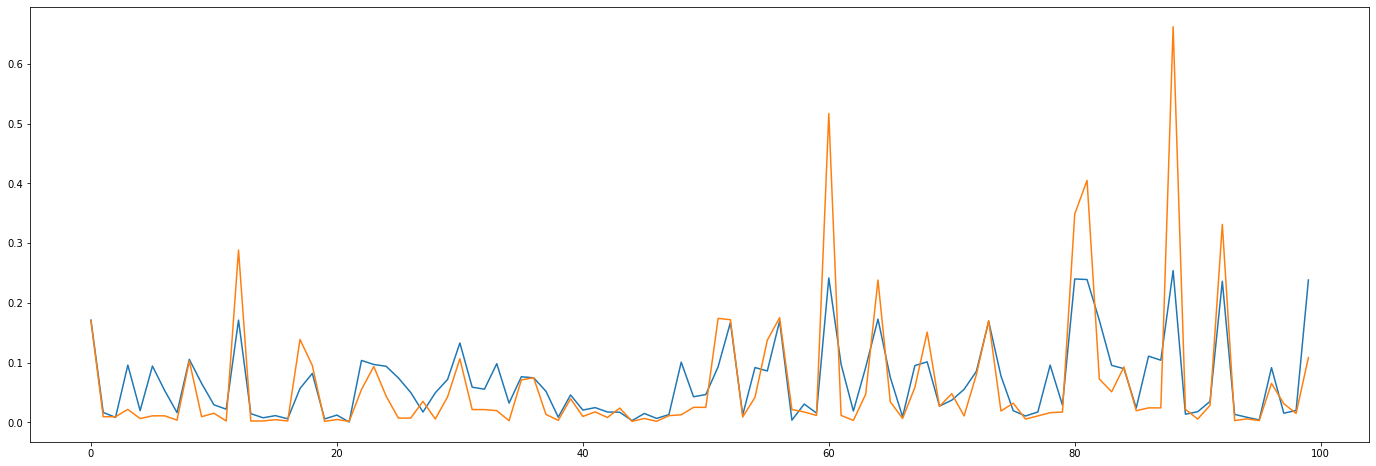

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (24, 8)
plt.plot(dataG['prediction'][:100], label = "Pred")  # Load the 500 data points from prediction with label name 'Pred'
plt.plot(dataG['violation_probability'][:100], label = "Actual")